Step 1: Import library

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# ==========================
# Data & basic tools
# ==========================
import pandas as pd
import numpy as np

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Statistical analysis
# ==========================
from scipy.stats import (
    ttest_ind, 
    levene, 
    chi2_contingency, 
    skew, 
    kurtosis, 
    pearsonr, 
    f_oneway
)
import statsmodels.api as sm

# ==========================
#  Structural Equation Modeling
# ==========================
from semopy import Model, calc_stats

# ==========================
# Time series modeling
# ==========================
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ==========================
# Machine Learning (Random Forest)
# ==========================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================
# Deep Learning (LSTM)
# ==========================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [3]:
df = pd.read_csv("../../Dataset/household.csv")

In [4]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
    'deg',
    'current',
    'voltage',
    'reactive_power',
    'apparent_power',
    'power_factor'
], axis=1)

Step 2.2: Load data and resample to hour

In [11]:

# change date column into datetime 
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# merge data by hour (mean)
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)  
      .reset_index()
)

print("The initial columns:", len(df), "→ After merging followed by hour:", len(df_hour))
df_hour

The initial columns: 605260 → After merging followed by hour: 10234


,date,active_power,temp,feels_like,pressure,humidity,speed
0,2022-11-05 14:00:00,248.780000,24.246364,23.728182,1011.909091,38.436364,0.081818
1,2022-11-05 15:00:00,202.663333,24.302000,23.765333,1010.666667,37.366667,2.912167
2,2022-11-05 16:00:00,198.863333,24.174000,23.605833,1011.416667,36.666667,2.322667
3,2022-11-05 17:00:00,390.181667,23.485667,22.830667,1010.600000,36.083333,2.455000
4,2022-11-05 18:00:00,443.036667,21.693667,20.933333,1008.816667,38.783333,2.269500
...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000


Step 2.3: Prepare some data columns

In [12]:


df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)

# Lag features
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()
df_hour.dropna(inplace=True)

Step 2.4: View data

In [13]:
df_hour

,date,active_power,temp,feels_like,pressure,humidity,speed,weekday,is_weekend,ap_lag_1h,ap_lag_24h,ap_roll_24h
24,2022-11-06 14:00:00,163.376667,28.653167,27.250167,1013.916667,21.083333,3.781167,6,1,224.355000,248.780000,273.720891
25,2022-11-06 15:00:00,297.003333,28.226667,26.947833,1013.016667,21.516667,4.559333,6,1,163.376667,202.663333,277.651724
26,2022-11-06 16:00:00,396.440000,27.816167,26.716833,1013.250000,22.916667,4.938667,6,1,297.003333,198.863333,285.884085
27,2022-11-06 17:00:00,311.295000,25.777500,25.265667,1013.166667,24.566667,4.757667,6,1,396.440000,390.181667,282.597141
28,2022-11-06 18:00:00,443.610000,23.328667,22.383333,1011.133333,25.483333,4.779167,6,1,311.295000,443.036667,282.621030
...,...,...,...,...,...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889,4,0,235.570833,293.395455,241.304597
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322,4,0,329.995556,342.735593,243.407775
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525,4,0,393.211864,396.593220,236.618439
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000,4,0,233.649153,406.398333,235.273231


Step 3. Implement models

3.7 SARIMAX Model


=== SARIMAX GRID SEARCH (Optimized 12 models) ===
SARIMAX(1, 0, 1)x(1, 0, 1, 24) → AIC=94298.27, MAE=104.310, RMSE=135.376
SARIMAX(1, 0, 1)x(0, 1, 1, 24) → AIC=94054.23, MAE=218.085, RMSE=255.406
SARIMAX(1, 0, 1)x(1, 1, 1, 24) → AIC=94067.49, MAE=217.894, RMSE=255.158
SARIMAX(2, 0, 1)x(1, 0, 1, 24) → AIC=94357.89, MAE=102.245, RMSE=133.486
SARIMAX(2, 0, 1)x(0, 1, 1, 24) → AIC=92261.09, MAE=432.529, RMSE=566.343
SARIMAX(2, 0, 1)x(1, 1, 1, 24) → AIC=94046.95, MAE=217.890, RMSE=254.796
SARIMAX(1, 1, 1)x(1, 0, 1, 24) → AIC=91685.92, MAE=215.151, RMSE=236.026
SARIMAX(1, 1, 1)x(0, 1, 1, 24) → AIC=91399.56, MAE=218.621, RMSE=257.631
SARIMAX(1, 1, 1)x(1, 1, 1, 24) → AIC=91589.70, MAE=219.571, RMSE=260.796
SARIMAX(2, 1, 1)x(1, 0, 1, 24) → AIC=91677.03, MAE=215.123, RMSE=235.970
SARIMAX(2, 1, 1)x(0, 1, 1, 24) → AIC=91599.94, MAE=219.520, RMSE=260.637
SARIMAX(2, 1, 1)x(1, 1, 1, 24) → AIC=92319.13, MAE=221.885, RMSE=267.919

=== BEST SARIMAX MODEL FOUND ===
Order = (1, 1, 1)
Seasonal = (0, 1, 1, 

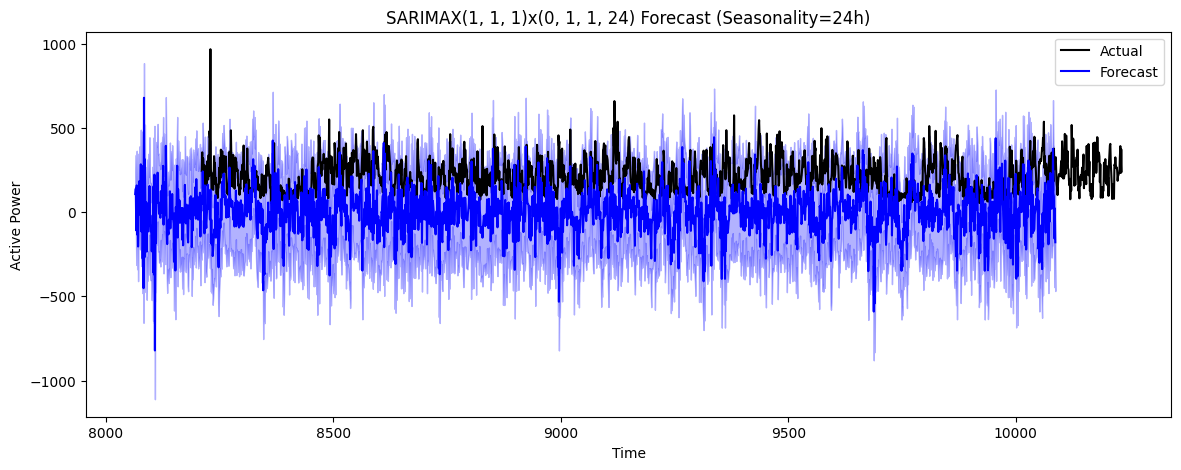

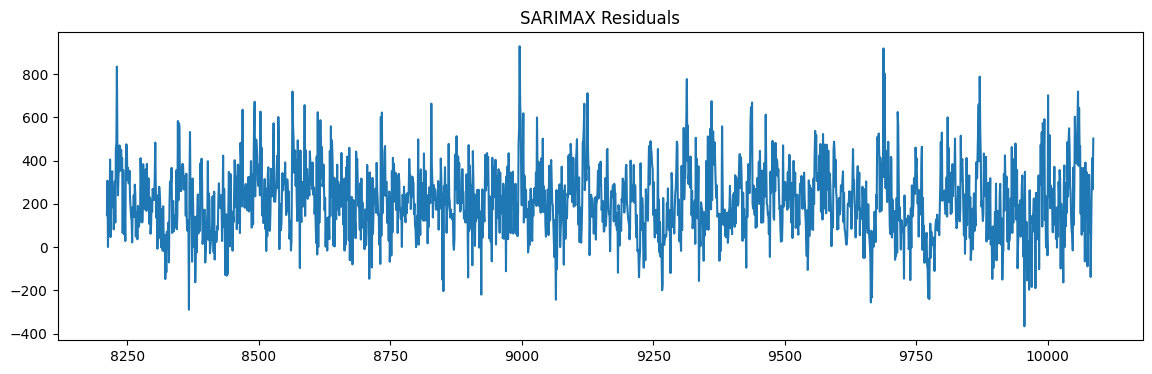

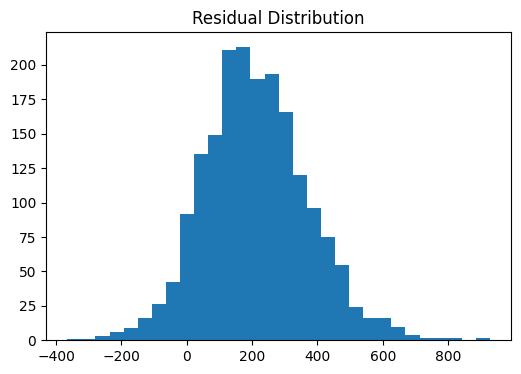

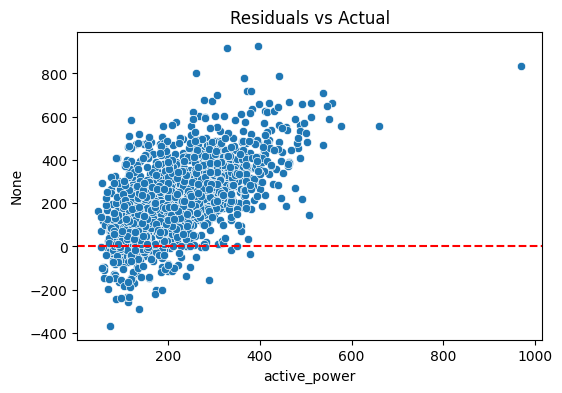

In [16]:
import warnings
warnings.filterwarnings("ignore")

from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


print("\n=== SARIMAX GRID SEARCH (Optimized 12 models) ===")

# ==== 1. Select exogenous variables ====
exog_vars = [
    v for v in ["temp", "humidity", "pressure", "speed",
                "ap_lag_1h", "ap_lag_24h", "ap_roll_24h"]
    if v in df_hour.columns
]
exog = df_hour[exog_vars]


# ==== 2. Train-test split ====
split = int(len(df_hour) * 0.8)
y_train = df_hour["active_power"][:split]
y_test  = df_hour["active_power"][split:]

exog_train = exog[:split]
exog_test  = exog[split:]


# ======================================================
# ==== 3. OPTIMIZED parameter grid (12 combinations) ====
# ======================================================

p_list = [(1,0,1), (2,0,1), (1,1,1), (2,1,1)]
seasonal_list = [(1,0,1,24), (0,1,1,24), (1,1,1,24)]

orders = p_list
seasonal_orders = seasonal_list

results = []


# ==== 4. Grid Search (Optimized) ====
for order in orders:
    for seasonal_order in seasonal_orders:

        try:
            model = SARIMAX(
                y_train,
                exog=exog_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing=True  # BOOST SPEED
            )

            res = model.fit(method="lbfgs", maxiter=70, disp=False)

            pred = res.get_forecast(steps=len(y_test), exog=exog_test)
            y_pred = pred.predicted_mean

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            results.append([order, seasonal_order, res.aic, mae, rmse])

            print(f"SARIMAX{order}x{seasonal_order} → "
                  f"AIC={res.aic:.2f}, MAE={mae:.3f}, RMSE={rmse:.3f}")

        except Exception as e:
            print(f"Skip SARIMAX{order}x{seasonal_order} → error: {e}")
            continue


# ==== 5. Select Best Model ====
results = sorted(results, key=lambda x: (x[2], x[3], x[4]))

best_order, best_seasonal, best_aic, best_mae, best_rmse = results[0]

print("\n=== BEST SARIMAX MODEL FOUND ===")
print(f"Order = {best_order}")
print(f"Seasonal = {best_seasonal}")
print(f"AIC = {best_aic:.2f}")
print(f"MAE = {best_mae:.3f}")
print(f"RMSE = {best_rmse:.3f}")


# ==== 6. Refit Best Model ====
best_model = SARIMAX(
    y_train,
    exog=exog_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True
)

best_res = best_model.fit(method="lbfgs", maxiter=70, disp=False)


# ==== 7. Forecast ====
forecast = best_res.get_forecast(steps=len(y_test), exog=exog_test)
y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()


# ==== 8. Plot Forecast ====
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label="Actual", color="black")
plt.plot(y_pred.index, y_pred, label="Forecast", color="blue")
plt.fill_between(y_pred.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color="blue", alpha=0.3)
plt.title(f"SARIMAX{best_order}x{best_seasonal} Forecast (Seasonality=24h)")
plt.xlabel("Time")
plt.ylabel("Active Power")
plt.legend()
plt.show()


# ==== 9. Residual Diagnostics ====
residuals = y_test - y_pred

plt.figure(figsize=(14,4))
plt.plot(residuals)
plt.title("SARIMAX Residuals")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Actual")
plt.show()
